# Part 1: Data Creation, Wranggling, Scrapping

# Sentiment Analysis with BERT using hugingface, PyTorch and Python


### Create Custom Dataset

In [28]:
!pip install -qq google-play-scraper

In [29]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [30]:
app_packages = [
      'com.anydo',
      'com.todoist',
      'com.ticktick.task',
      'com.habitrpg.android.habitica',
      'cc.forestapp',
      'com.oristats.habitbull',
      'com.levor.liferpgtasks',
      'com.habitnow',
      'com.microsoft.todos',
      'prox.lab.calclock',
      'com.gmail.jmartindev.timetune',
      'com.artfulagenda.app',
      'com.tasks.android',
      'com.appgenix.bizcal',
      'com.appxy.planner'
]

In [31]:
len(app_packages)

15

In [32]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


In [33]:
def print_json(json_object):
  json_str = json.dumps(
      json_object,
      indent=2,
      sort_keys=True,
      default=str
  )

  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [34]:
print_json(app_infos[8])

{
  "adSupported": false,
  "appId": "com.microsoft.todos",
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Microsoft To Do is a task management app to help you stay organized and manage your day-to-day. You can use Microsoft To Do to make shopping lists or task lists, take notes, record collections, plan an event, or set reminders to increase your productivity and focus on what matters to you. Microsoft To Do makes it easy to stay organized and manage your life.\r\n\r\nAccomplish what's meaningful and important to you each day with My Day and Suggestions, your personalized daily planner tools. Intelligent suggestions recommend tasks from across your lists that may be relevant for the day. From grocery lists to housecleaning routines, daily tasks are simple with To Do. When you're quickly switching between contexts and tasks, it's important to have tools that help you achieve what matters. Microsoft To Do

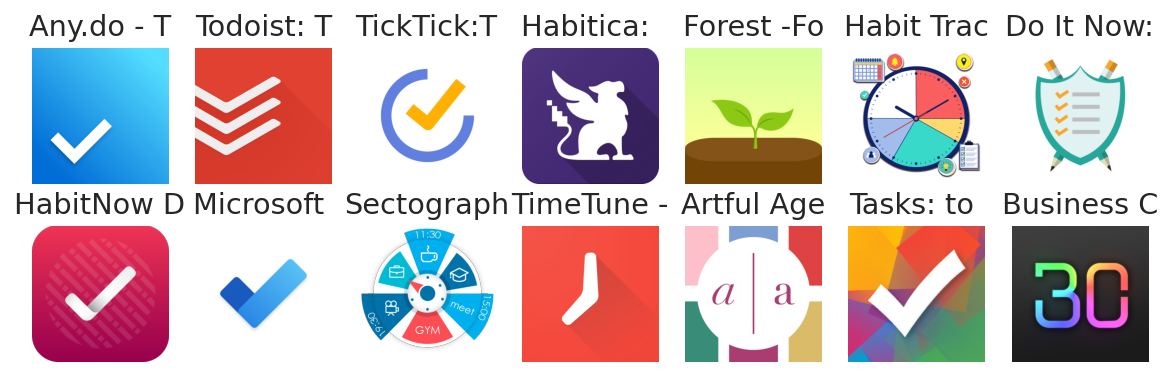

In [35]:
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(10, 3))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(ai['title'][:10])
  ax.axis('off')

In [36]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

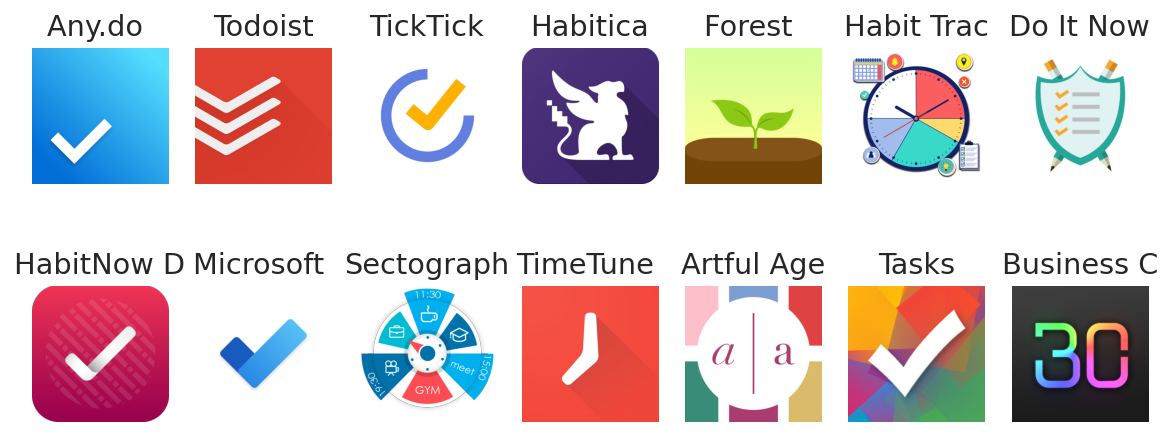

In [37]:
fig, axs = plt.subplots(2, len(app_infos)//2, figsize=(10, 4))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title'][:10]))
  ax.axis('off')

In [38]:
app_infos_df = pd.DataFrame(app_infos)

app_infos_df.head(2)

,title,description,descriptionHTML,summary,installs,minInstalls,score,ratings,reviews,histogram,...,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,Any.do - To do list & Calendar,"🥇 <b>""#1 to do list app out there”</b> - WSJ\r...",🥇 <b>&quot;#1 to do list app out there”</b> - ...,"Simple planner with to-do list, tasks, reminde...","10,000,000+",10000000,4.357462,434519,35618,"[32323, 10997, 26314, 64259, 300614]",...,None,False,False,"Nov 10, 2011",1644346628,Varies with device,What's new?\r\n- Filters! You can now filter y...,What&#39;s new?<br>- Filters! You can now filt...,com.anydo,https://play.google.com/store/apps/details?id=...
1,Todoist: To-Do List & Tasks,"🏆 <b>2020 Editor's Choice</b> by Google\r\n🥇 ""...",🏆 <b>2020 Editor&#39;s Choice</b> by Google<br...,“The best to-do list app right now” - The Verg...,"10,000,000+",10000000,4.512061,241908,15529,"[13561, 4860, 8136, 32911, 182428]",...,None,False,False,"Nov 18, 2012",1654193971,Varies with device,🌟 Introducing an all-new task view! \r\n\r\nBr...,🌟 Introducing an all-new task view! <br><br>Br...,com.todoist,https://play.google.com/store/apps/details?id=...


In [41]:
app_infos_df.columns

Index(['title', 'description', 'descriptionHTML', 'summary', 'installs',
       'minInstalls', 'score', 'ratings', 'reviews', 'histogram', 'price',
       'free', 'currency', 'sale', 'saleTime', 'originalPrice', 'saleText',
       'offersIAP', 'inAppProductPrice', 'developer', 'developerId',
       'developerEmail', 'developerWebsite', 'developerAddress',
       'privacyPolicy', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'recentChangesHTML', 'appId',
       'url'],
      dtype='object')

In [39]:
app_infos_df.to_csv('app.csv', index=None, header=None)

#### Get App Reviews

In [50]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 15/15 [01:11<00:00,  4.80s/it]


In [51]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2022-04-25 15:55:21",
  "content": "I used to love this app. I have used it for years. I even had (until yesterday) the paid version. I primarily use this app to sync up my alexa tasks. It started having issues, then got fixed. Now the company is saying that Amazon sync is no longer usable (unless you want to add a 3rd party to allow it access to your Amazon account).",
  "repliedAt": "2022-04-26 16:53:39",
  "replyContent": "Unfortunately, Amazon has rejected our fix and will not be reopening the Any.do Skill just yet.\nAt this point in time, our efforts seem to be blocked and we will not be able to offer with any estimate to when the integration will be reactivated :(",
  "reviewCreatedVersion": "5.15.4.2",
  "reviewId": "gp:AOqpTOETV_gyK_4K53K_0hip-ofKkumdJlGwWUBestuc2C_oLqjFdhRj5E40paAyMwaeTXyfcvUm-I2XFcmvoQ",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 35,
  "userImage": "https://play-lh.googleusercontent.com/a/AATXAJzFdtk_AS

In [52]:
app_reviews_df = pd.DataFrame(app_reviews)

app_reviews_df.shape

(16962, 12)

In [53]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOETV_gyK_4K53K_0hip-ofKkumdJlGwWUBestu...,Brent Schoemann,https://play-lh.googleusercontent.com/a/AATXAJ...,I used to love this app. I have used it for ye...,1,35,5.15.4.2,2022-04-25 15:55:21,"Unfortunately, Amazon has rejected our fix and...",2022-04-26 16:53:39,most_relevant,com.anydo
1,gp:AOqpTOG-nGuDe0w6if400pTvNJnK3MlfnEcJLIB84aR...,Ben Maybe,https://play-lh.googleusercontent.com/a/AATXAJ...,But the paid version for a year and never succ...,1,60,5.15.4.2,2022-03-01 17:18:50,"Hi, we're sorry to hear you're experiencing is...",2022-03-01 15:53:58,most_relevant,com.anydo
2,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,76,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
3,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Anthony Cannon,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,81,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
4,gp:AOqpTOECnmXVoFIJ9QXAK5krNRuVmF7Xpl-Xbutb2KH...,Emie Hickman,https://play-lh.googleusercontent.com/a-/AOh14...,After a task is done a duplicate will appear f...,1,1,None,2022-02-22 03:24:11,We would be happy to help you resolve all of t...,2022-02-24 16:34:04,most_relevant,com.anydo


In [54]:
app_reviews_df.to_csv('reviews.csv', index=None, header=True)